In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.5,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_05_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:46 - loss: 0.0177 - STD: 1.3796e-04 - MAE: 0.1191

 15/632 [..............................] - ETA: 2s - loss: 0.0157 - STD: 0.0016 - MAE: 0.0823       

 28/632 [>.............................] - ETA: 2s - loss: 0.0138 - STD: 0.0042 - MAE: 0.0761

 40/632 [>.............................] - ETA: 9s - loss: 0.0125 - STD: 0.0126 - MAE: 0.0710

 56/632 [=>............................] - ETA: 6s - loss: 0.0102 - STD: 0.0321 - MAE: 0.0635

 69/632 [==>...........................] - ETA: 5s - loss: 0.0090 - STD: 0.0442 - MAE: 0.0586

 82/632 [==>...........................] - ETA: 5s - loss: 0.0080 - STD: 0.0522 - MAE: 0.0549

 96/632 [===>..........................] - ETA: 4s - loss: 0.0073 - STD: 0.0591 - MAE: 0.0519

113/632 [====>.........................] - ETA: 3s - loss: 0.0066 - STD: 0.0656 - MAE: 0.0492

129/632 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0472

143/632 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0730 - MAE: 0.0456

157/632 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0443

172/632 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0431

186/632 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0421

199/632 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0414

213/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0407

225/632 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0402

237/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0396

251/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0859 - MAE: 0.0390

264/632 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0869 - MAE: 0.0386

278/632 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0878 - MAE: 0.0381

290/632 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0885 - MAE: 0.0377

303/632 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0891 - MAE: 0.0374

316/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0897 - MAE: 0.0370

328/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0367

340/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0364

353/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0362

366/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0359

380/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0356

394/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0354

406/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0351

418/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0349

431/632 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0347

444/632 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0940 - MAE: 0.0345

460/632 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0343

477/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0341

493/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0339

511/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0952 - MAE: 0.0337

526/632 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0335

539/632 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0334

556/632 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0332

574/632 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0330

589/632 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0966 - MAE: 0.0329

601/632 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0328

614/632 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0970 - MAE: 0.0327

627/632 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0971 - MAE: 0.0325

632/632 [==============================] - 4s 5ms/step - loss: 0.0026 - STD: 0.0972 - MAE: 0.0325 - val_loss: 0.0017 - val_STD: 0.0789 - val_MAE: 0.0286


Epoch 2/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

 14/632 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275 

 28/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

 42/632 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

 55/632 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0287

 68/632 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

 81/632 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

 93/632 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

106/632 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

119/632 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

133/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0279

146/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279

159/632 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

176/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

189/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

202/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

214/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

226/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

239/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

253/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

265/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

277/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

291/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

304/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

316/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

328/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

341/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

354/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

371/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

389/632 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

406/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

422/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

438/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

455/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

472/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

490/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

508/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

525/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

542/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

559/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

576/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

590/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

608/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

626/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

632/632 [==============================] - 2s 4ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275 - val_loss: 0.0015 - val_STD: 0.0784 - val_MAE: 0.0280


Epoch 3/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

 18/632 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0264 

 34/632 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

 51/632 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

 64/632 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

 80/632 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

 94/632 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

106/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

120/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

134/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

151/632 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

169/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

186/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

203/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

221/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

234/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

248/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

262/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

278/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

295/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

312/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

327/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

341/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

354/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

369/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

385/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

399/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

415/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

432/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

449/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

466/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

483/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

500/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

517/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

535/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

552/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

569/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

585/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

601/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

618/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0014 - val_STD: 0.0774 - val_MAE: 0.0274


Epoch 4/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0262

 14/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0261 

 30/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

 46/632 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

 62/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

 79/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

 97/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

114/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

130/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

146/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

162/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

178/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

193/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

209/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

226/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

244/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

262/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

280/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

298/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

316/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

334/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

352/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

368/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

384/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

401/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

417/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

433/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

449/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

466/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

484/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

502/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

520/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

538/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

554/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

568/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

585/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

602/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

619/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

632/632 [==============================] - 2s 3ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0814 - val_MAE: 0.0283


Epoch 5/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0015 - STD: 0.1137 - MAE: 0.0264

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0261 

 28/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0259

 41/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0258

 54/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0257

 67/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0258

 80/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0259

 95/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0259

112/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

127/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

140/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

153/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

166/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

180/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

195/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

210/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

222/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

236/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

251/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

266/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

281/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

297/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

314/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

330/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

343/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

359/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

376/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

392/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

406/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

419/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

434/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

451/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

469/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

487/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

503/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

515/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

527/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

540/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

553/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

569/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

584/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

596/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

610/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

625/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256 - val_loss: 0.0014 - val_STD: 0.0817 - val_MAE: 0.0267


Epoch 6/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0011 - STD: 0.1151 - MAE: 0.0235

 16/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266 

 32/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

 49/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

 67/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

 83/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

 96/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

111/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

128/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

143/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

156/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

170/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

183/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

195/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

208/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

220/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

232/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

245/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

260/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

274/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

287/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

301/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

315/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

329/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

344/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

357/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

371/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

388/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

401/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

414/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

427/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

439/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

451/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

463/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

476/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

491/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

508/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

525/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

538/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

555/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

574/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

591/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

606/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

621/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

632/632 [==============================] - 2s 4ms/step - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252 - val_loss: 0.0018 - val_STD: 0.0818 - val_MAE: 0.0298


Epoch 7/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0016 - STD: 0.1136 - MAE: 0.0265

 17/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0259 

 30/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0254

 43/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1078 - MAE: 0.0253

 55/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0253

 67/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0253

 83/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0253

 98/632 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0252

111/632 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0251

127/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

145/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

162/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

180/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

195/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0249

213/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

231/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

248/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

265/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

279/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

292/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

304/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

318/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

336/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

355/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

373/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

390/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

408/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

425/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

441/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

458/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

476/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

492/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

509/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

526/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

539/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

556/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

570/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

586/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

603/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

620/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

632/632 [==============================] - 2s 4ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247 - val_loss: 0.0014 - val_STD: 0.0826 - val_MAE: 0.0258


Epoch 8/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1095 - MAE: 0.0239

 15/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1094 - MAE: 0.0242 

 31/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1078 - MAE: 0.0241

 46/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0245

 63/632 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0245

 80/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0244

 97/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0242

112/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0242

126/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0242

142/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0242

156/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0242

172/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0242

190/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0242

207/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0242

224/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0242

241/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

258/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

276/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

293/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

310/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

324/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

339/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

355/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

372/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

388/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

404/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

420/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

437/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

452/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

466/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

483/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

501/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

518/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

534/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

549/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

566/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

582/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

598/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

615/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

631/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

632/632 [==============================] - 2s 3ms/step - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241 - val_loss: 0.0014 - val_STD: 0.0803 - val_MAE: 0.0264


Epoch 9/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0236

 16/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0237 

 34/632 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0237

 51/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

 68/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0237

 85/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0238

100/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0239

112/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0238

125/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0239

137/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0239

152/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0239

168/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

184/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0238

201/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0239

217/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0239

234/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0239

250/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0239

266/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

280/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

293/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

305/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

319/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

337/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

355/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

373/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

390/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

408/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

425/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

443/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

461/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

478/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

495/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

512/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

529/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

546/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

563/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

581/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

598/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

614/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

630/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

632/632 [==============================] - 2s 3ms/step - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237 - val_loss: 0.0016 - val_STD: 0.0855 - val_MAE: 0.0269


Epoch 10/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0010 - STD: 0.1126 - MAE: 0.0219

 18/632 [..............................] - ETA: 1s - loss: 0.0011 - STD: 0.1093 - MAE: 0.0235 

 35/632 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0244

 51/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

 68/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

 85/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0241

102/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

119/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

135/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

152/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

168/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0240

185/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0240

202/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0240

219/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

236/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

252/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

269/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

286/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

304/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

322/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

338/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

355/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

371/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0236

388/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0236

404/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0236

420/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

436/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

452/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

468/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

485/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

502/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

519/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

536/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0235

551/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

567/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

584/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

601/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

618/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

632/632 [==============================] - 2s 3ms/step - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235 - val_loss: 0.0016 - val_STD: 0.0846 - val_MAE: 0.0270


Epoch 11/10000


  1/632 [..............................] - ETA: 11s - loss: 9.7708e-04 - STD: 0.1005 - MAE: 0.0217

 17/632 [..............................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0231     

 33/632 [>.............................] - ETA: 1s - loss: 0.0011 - STD: 0.1082 - MAE: 0.0231

 50/632 [=>............................] - ETA: 1s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0232

 67/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1082 - MAE: 0.0232

 83/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

 99/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0233

116/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

132/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

148/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0233

164/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

179/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

192/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

205/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

220/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

235/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

251/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

264/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

277/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

293/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

311/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

329/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

344/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

360/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

375/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

391/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

406/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

422/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

437/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

452/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

465/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

481/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

498/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

515/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

532/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

549/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

566/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

583/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

600/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

616/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

632/632 [==============================] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

632/632 [==============================] - 2s 4ms/step - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231 - val_loss: 0.0020 - val_STD: 0.0850 - val_MAE: 0.0302


Epoch 12/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0011 - STD: 0.1168 - MAE: 0.0235

 18/632 [..............................] - ETA: 1s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0232 

 33/632 [>.............................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

 47/632 [=>............................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0233

 64/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0231

 80/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

 96/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

113/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

127/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

143/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

159/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0229

173/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0229

187/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

201/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

217/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

231/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

243/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

256/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

269/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

282/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

299/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

316/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

332/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

348/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

365/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

382/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

399/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

415/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

430/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

444/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

459/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

476/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

494/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

511/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

528/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

544/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

561/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

578/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

594/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

606/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

619/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

632/632 [==============================] - 2s 4ms/step - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228 - val_loss: 0.0016 - val_STD: 0.0811 - val_MAE: 0.0270


Epoch 13/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0012 - STD: 0.1098 - MAE: 0.0240

 14/632 [..............................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227 

 30/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0227

 47/632 [=>............................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

 65/632 [==>...........................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

 79/632 [==>...........................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

 94/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

111/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0228

128/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

141/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

157/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

172/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0228

186/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

200/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

214/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

228/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

242/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

256/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0228

270/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0228

283/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

295/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

308/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

322/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

339/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

357/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

375/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0227

393/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0227

410/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

428/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0228

446/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

464/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

482/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

500/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1074 - MAE: 0.0227

518/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

536/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

554/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

572/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

589/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

607/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

625/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

632/632 [==============================] - 2s 3ms/step - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227 - val_loss: 0.0014 - val_STD: 0.0823 - val_MAE: 0.0262


Epoch 14/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

 17/632 [..............................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229 

 35/632 [>.............................] - ETA: 1s - loss: 0.0011 - STD: 0.1090 - MAE: 0.0227

 53/632 [=>............................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

 72/632 [==>...........................] - ETA: 1s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0223

 90/632 [===>..........................] - ETA: 1s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0222

107/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0222

123/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1085 - MAE: 0.0222

140/632 [=====>........................] - ETA: 1s - loss: 0.0010 - STD: 0.1084 - MAE: 0.0222

157/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0223

175/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0224

192/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0223

210/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0224

227/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0224

246/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0224

263/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0224

279/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

296/632 [=============>................] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

311/632 [=============>................] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

327/632 [==============>...............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

343/632 [===============>..............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

361/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

379/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

397/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

409/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

421/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

437/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

450/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

464/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

481/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

498/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

516/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

534/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

552/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

569/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

587/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

605/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

623/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

632/632 [==============================] - 2s 3ms/step - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224 - val_loss: 0.0027 - val_STD: 0.0923 - val_MAE: 0.0336


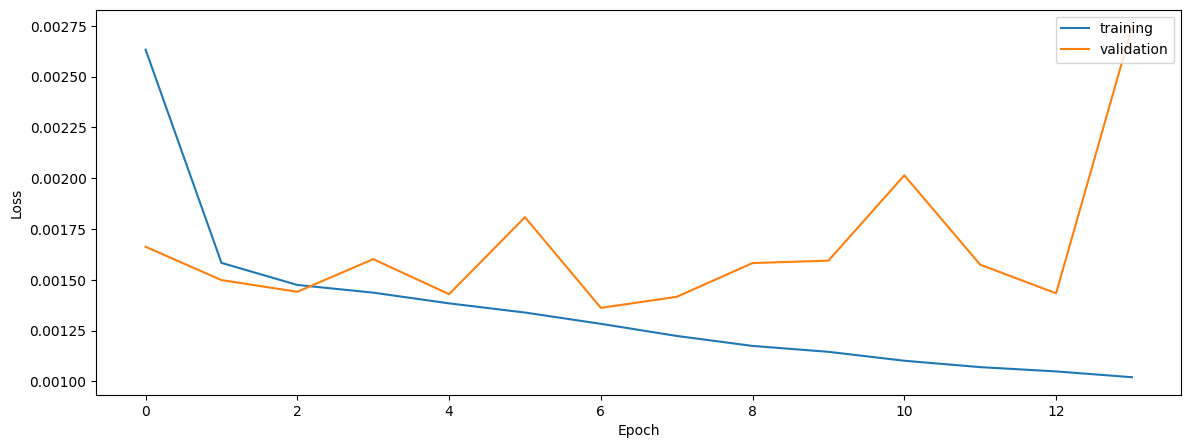

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9515844397656532
0.9602626281331766
0.948557449129117


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9515844397656532
0.9602626281331766
0.948557449129117


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9571922738257448
0.962583651282852
0.9599458405333111


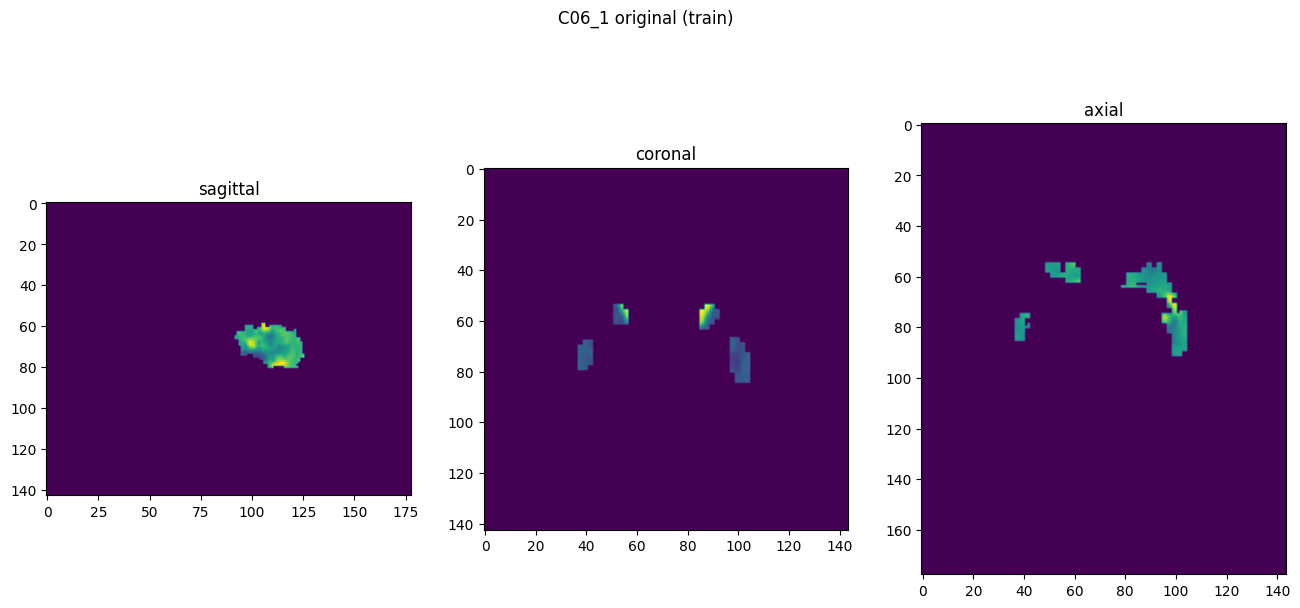

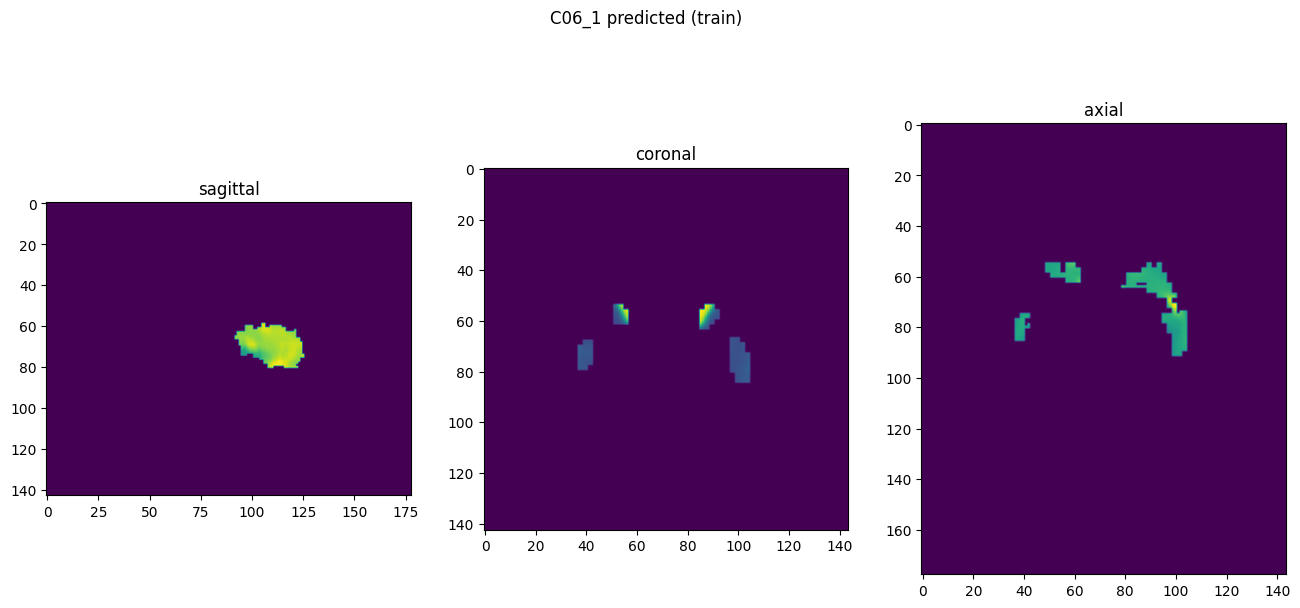

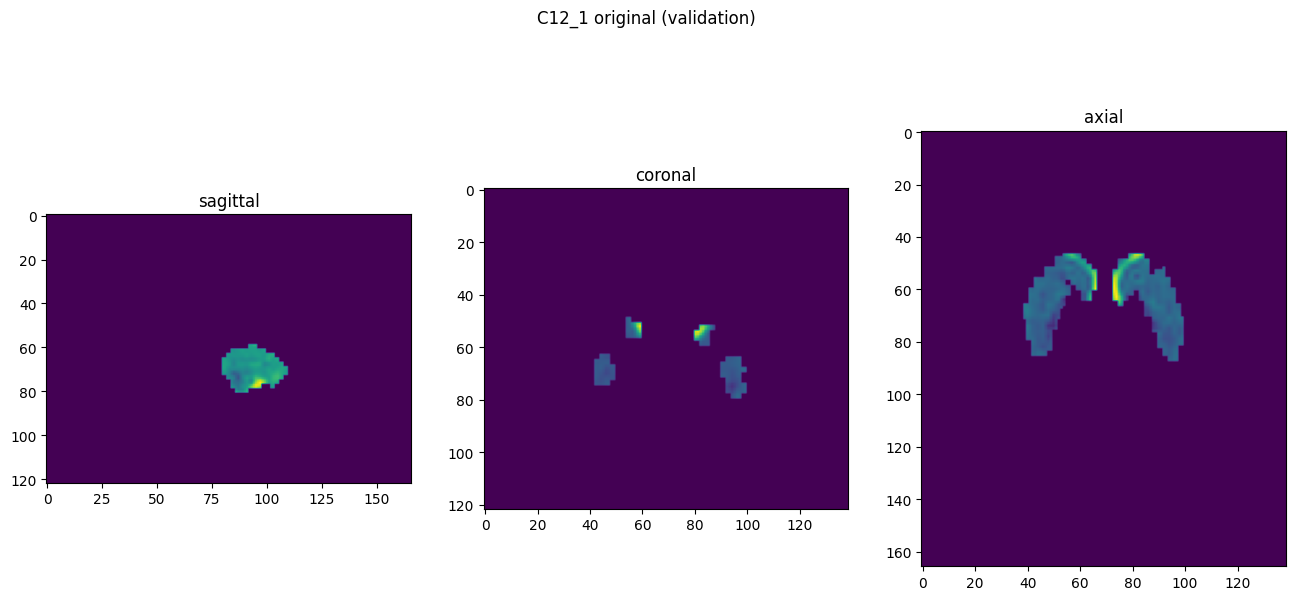

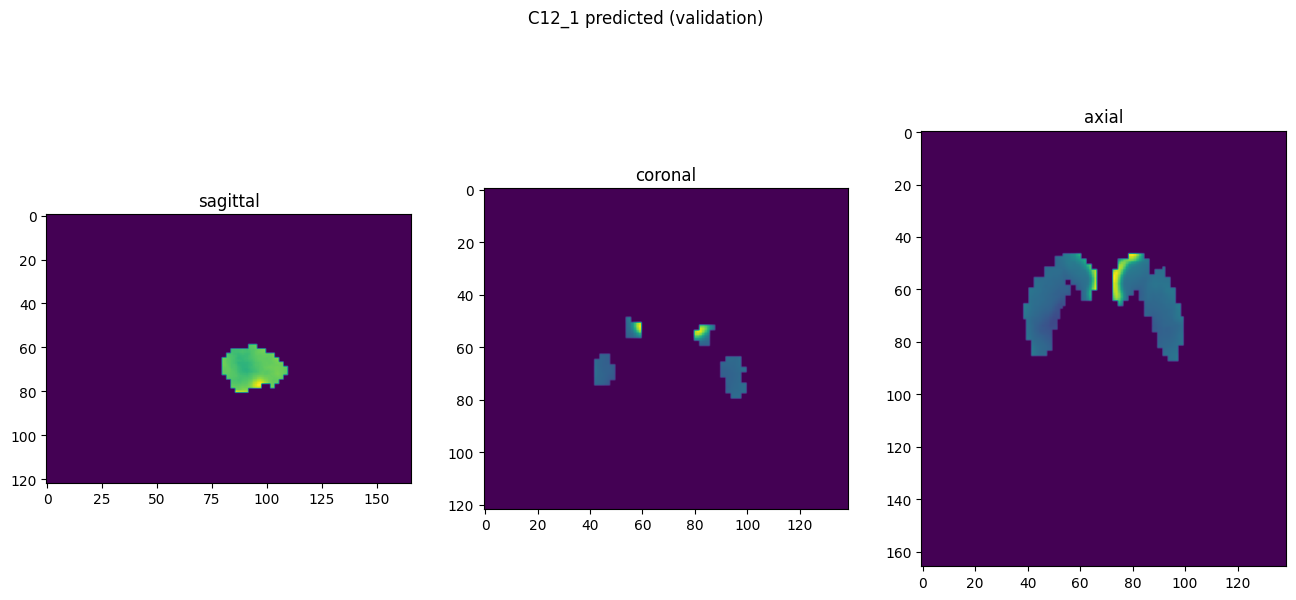

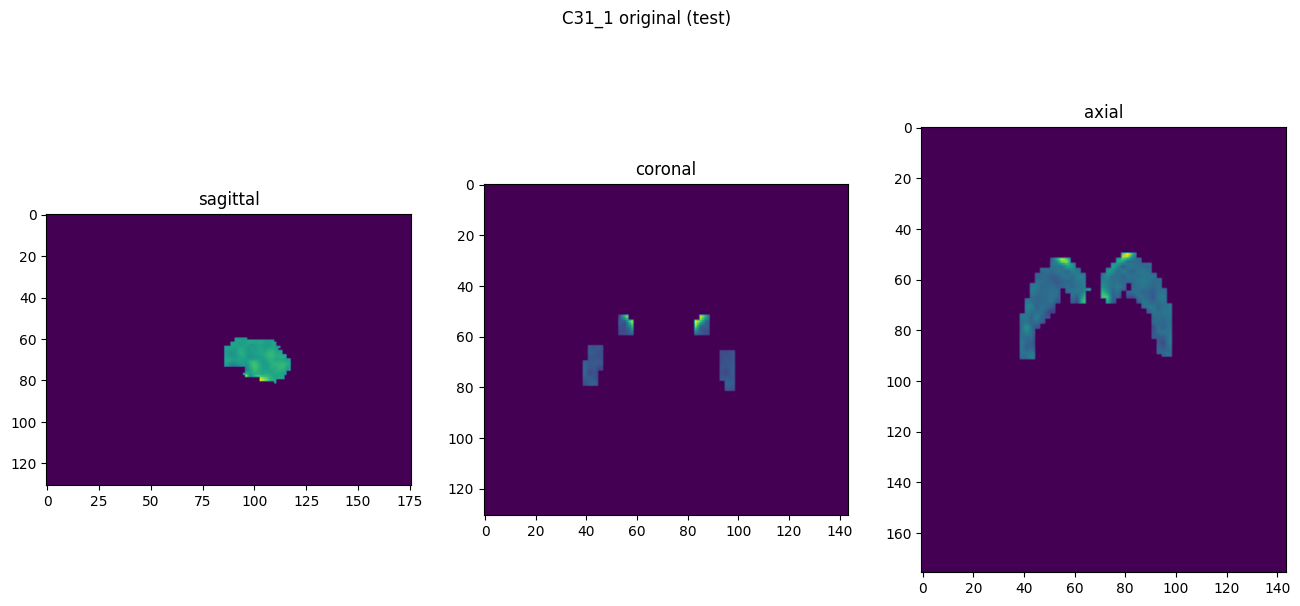

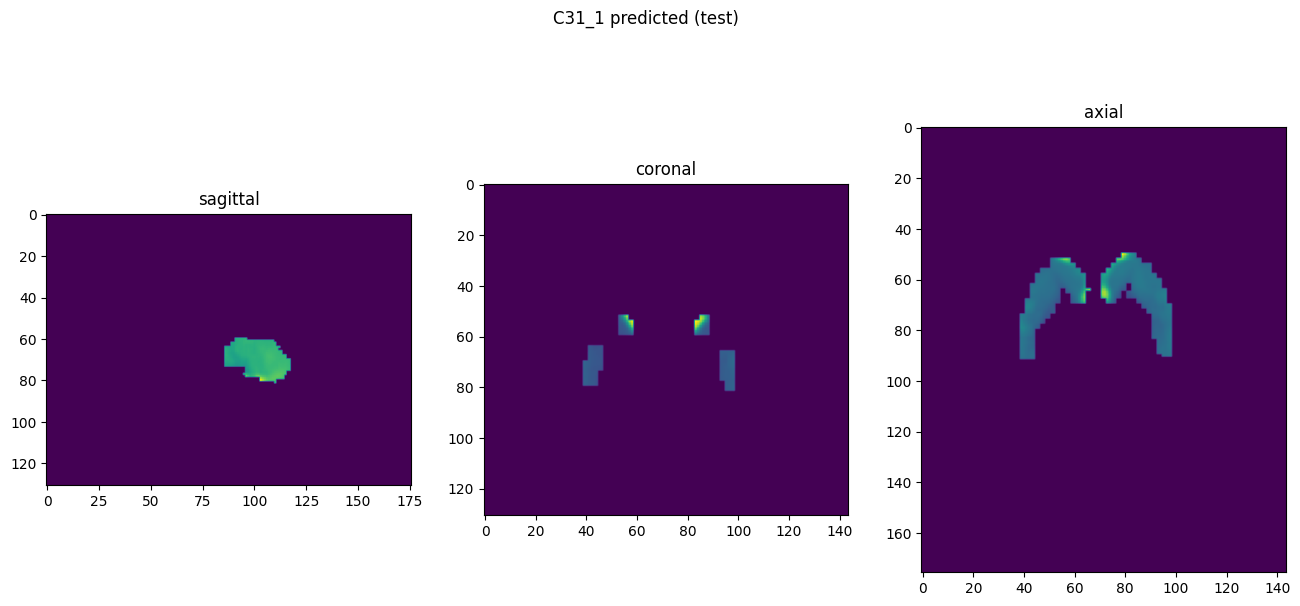

In [10]:
showResults(model, gen, threshold=None, background=False)